In [1]:
import pandas as pd
from mrmr import mrmr_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Flatten, Lambda, Conv1D, Layer
from tensorflow.keras.models import Sequential

In [95]:
train_data = pd.read_csv("C:\\123\\SRMAP\\Semester 5\\UROP\\\Train and Test dataset\\KDDTrain+.txt", header=None)
test_data = pd.read_csv("C:\\123\\SRMAP\\Semester 5\\UROP\\Train and Test dataset\\KDDTest+.txt", header=None)

In [96]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_data.columns = columns
test_data.columns = columns

# sanity check
train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [97]:
# map normal to 0, all attacks to 1
train_attack = train_data.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_data.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
train_data['attack_bit'] = train_attack
test_data['attack_bit'] = test_attack

# view the result
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_bit
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,1
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,1
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,1
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,1


In [98]:
train_data['attack_bit'].value_counts()

attack_bit
0    67343
1    58630
Name: count, dtype: int64

In [99]:
train_data_attack = train_data[train_data['attack_bit']==1]
train_data_attack.shape

(58630, 44)

In [100]:
train_data_non_attack = train_data[train_data['attack_bit']==0]
train_data_non_attack.shape

(67343, 44)

In [101]:
train_data_non_attack_downsampled = train_data_non_attack.sample(train_data_attack.shape[0])
train_data_non_attack_downsampled.shape

(58630, 44)

In [102]:
train_data_balanced = pd.concat([train_data_non_attack_downsampled, train_data_attack])
train_data_balanced.shape

(117260, 44)

In [103]:
columns_to_drop = ['attack_bit', 'level', 'attack']

In [104]:
x_train = train_data_balanced.drop(columns=columns_to_drop, axis=1)
y_train = train_data_balanced['attack_bit']

numeric_columns1 = x_train.select_dtypes(include=['number']).columns
categorical_columns1 = x_train.select_dtypes(exclude=['number']).columns
X_categorical1 = pd.get_dummies(x_train[categorical_columns1], drop_first=True)
train = pd.concat([x_train[numeric_columns1], X_categorical1], axis=1)
train = train.astype(int)

In [105]:
train.head(20)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
48255,0,371,7931,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
19193,6616,147,105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
120968,910,147,105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
96813,0,272,769,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8269,4382,147,105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12099,0,320,482,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
34170,0,210,11933,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
111384,0,281,756,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
100027,0,43,127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
124955,0,4763,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [106]:
x_test = test_data.drop(columns=columns_to_drop, axis=1)
y_test = test_data['attack_bit']

numeric_columns2 = x_test.select_dtypes(include=['number']).columns
categorical_columns2 = x_test.select_dtypes(exclude=['number']).columns
X_categorical2 = pd.get_dummies(x_test[categorical_columns2], drop_first=True)
test = pd.concat([x_test[numeric_columns2], X_categorical2], axis=1)
test = test.astype(int)
test.head(20)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,267,14515,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,0,1022,387,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,0,129,174,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,327,467,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,0,26,157,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [107]:
x_train, x_val, y_train, y_val = train_test_split(train, y_train, test_size=0.3, random_state=42)

In [108]:
selected_features = mrmr_classif(x_train, y_train, 20) # Select 10 features
X_train_selected = x_train[selected_features]
X_val_selected = x_val[selected_features]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


In [109]:
print(X_train_selected)

        flag_SF  dst_host_srv_count  logged_in  same_srv_rate   
92769         0                   1          0              1  \
88703         0                   1          0              1   
12973         1                 159          1              1   
42613         0                   2          0              1   
90038         1                  75          0              1   
...         ...                 ...        ...            ...   
38902         1                   4          1              1   
110840        0                   6          0              0   
96801         0                   2          0              1   
104866        1                 229          0              1   
6772          1                 255          1              1   

        dst_host_srv_serror_rate  srv_serror_rate  count  flag_S0   
92769                          0                0      1        0  \
88703                          0                0      1        0   
12973       

In [9]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_selected)
# clf = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

In [11]:
 #clf.fit(X_train, y_train)
# num_epochs = 5 # Specify the number of "epochs" you want
# for epoch in range(num_epochs):
#     clf.fit(X_train, y_train)
# You can perform any necessary evaluations or updates here

In [16]:
# X_test_selected = test[selected_features]
# X_test = scaler.transform(X_test_selected)
# accuracy = model.score(X_test, y_test)
# print(f"Accuracy: {accuracy}")

In [110]:
class RBFNLayer(Layer):
    def __init__(self, num_rbf_units, **kwargs):
        super(RBFNLayer, self).__init__(**kwargs)
        self.num_rbf_units = num_rbf_units

    def build(self, input_shape):
        # Create RBFN centers as trainable variables
        self.centers = self.add_weight("centers",
                                      shape=(self.num_rbf_units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        super(RBFNLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute the RBF activations
        diff = tf.expand_dims(inputs, axis=-2) - self.centers
        diff = tf.norm(diff, axis=-1)
        rbf_activations = tf.exp(-diff)
        return rbf_activations

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_rbf_units)

In [112]:
# Standardize the data
scaler = StandardScaler()
X_train_selected_scalar = scaler.fit_transform(X_train_selected)
X_val_selected_scalar = scaler.transform(X_val_selected)

In [113]:
# Create a Sequential model with CNN, GRU layers, and an RBF layer
model = Sequential()

# Add a 1D CNN layer
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train_selected_scalar.shape[1], 1)))

# Add GRU layers
model.add(GRU(64, activation='tanh', return_sequences=True))
model.add(GRU(32, activation='tanh'))

# Add an RBF layer
#model.add(Dense(1, activation='linear'))
model.add(RBFNLayer(num_rbf_units=1))

In [114]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# Reshape X_train for compatibility with GRU
X_train_selected_scalar_reshape = X_train_selected_scalar.reshape(X_train_selected_scalar.shape[0], X_train_selected_scalar.shape[1], 1)

In [115]:
# Train the model
model.fit(X_train_selected_scalar_reshape, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
2309/2309 [==============================] - 68s 27ms/step - loss: 0.1618 - accuracy: 0.9467 - precision: 0.9700 - recall: 0.9225 - val_loss: 0.1136 - val_accuracy: 0.9670 - val_precision: 0.9754 - val_recall: 0.9573
Epoch 2/5
2309/2309 [==============================] - 60s 26ms/step - loss: 0.1001 - accuracy: 0.9691 - precision: 0.9782 - recall: 0.9600 - val_loss: 0.1021 - val_accuracy: 0.9675 - val_precision: 0.9839 - val_recall: 0.9497
Epoch 3/5
2309/2309 [==============================] - 60s 26ms/step - loss: 0.0918 - accuracy: 0.9708 - precision: 0.9802 - recall: 0.9614 - val_loss: 0.0870 - val_accuracy: 0.9706 - val_precision: 0.9801 - val_recall: 0.9600
Epoch 4/5
2309/2309 [==============================] - 61s 26ms/step - loss: 0.0873 - accuracy: 0.9724 - precision: 0.9816 - recall: 0.9631 - val_loss: 0.0819 - val_accuracy: 0.9719 - val_precision: 0.9816 - val_recall: 0.9610
Epoch 5/5
2309/2309 [==============================] - 60s 26ms/step - loss: 0.0815 - accura

In [20]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
3298/3298 [==============================] - 33s 10ms/step - loss: 0.0459 - accuracy: 0.9832 - precision: 0.9839 - recall: 0.9782 - val_loss: 0.0559 - val_accuracy: 0.9824 - val_precision: 1.0000 - val_recall: 0.9824
Epoch 2/50
3298/3298 [==============================] - 31s 9ms/step - loss: 0.0459 - accuracy: 0.9833 - precision: 0.9835 - recall: 0.9789 - val_loss: 0.0563 - val_accuracy: 0.9816 - val_precision: 1.0000 - val_recall: 0.9816
Epoch 3/50
3298/3298 [==============================] - 31s 9ms/step - loss: 0.0468 - accuracy: 0.9832 - precision: 0.9836 - recall: 0.9786 - val_loss: 0.0529 - val_accuracy: 0.9833 - val_precision: 1.0000 - val_recall: 0.9833
Epoch 4/50
3298/3298 [==============================] - 31s 9ms/step - loss: 0.0457 - accuracy: 0.9834 - precision: 0.9836 - recall: 0.9789 - val_loss: 0.0520 - val_accuracy: 0.9823 - val_precision: 1.0000 - val_recall: 0.9823
Epoch 5/50
3298/3298 [==============================] - 33s 10ms/step - loss: 0.0460 - accu

Epoch 37/50
3298/3298 [==============================] - 32s 10ms/step - loss: 0.0448 - accuracy: 0.9837 - precision: 0.9835 - recall: 0.9797 - val_loss: 0.0575 - val_accuracy: 0.9791 - val_precision: 1.0000 - val_recall: 0.9791
Epoch 38/50
3298/3298 [==============================] - 32s 10ms/step - loss: 0.0455 - accuracy: 0.9834 - precision: 0.9831 - recall: 0.9794 - val_loss: 0.0798 - val_accuracy: 0.9751 - val_precision: 1.0000 - val_recall: 0.9751
Epoch 39/50
3298/3298 [==============================] - 32s 10ms/step - loss: 0.0451 - accuracy: 0.9834 - precision: 0.9838 - recall: 0.9789 - val_loss: 0.0566 - val_accuracy: 0.9795 - val_precision: 1.0000 - val_recall: 0.9795
Epoch 40/50
3298/3298 [==============================] - 33s 10ms/step - loss: 0.0459 - accuracy: 0.9832 - precision: 0.9830 - recall: 0.9791 - val_loss: 0.0653 - val_accuracy: 0.9811 - val_precision: 1.0000 - val_recall: 0.9811
Epoch 41/50
3298/3298 [==============================] - 35s 11ms/step - loss: 0.045

In [21]:
model.save("CNN_and_GRU_and_RBNF_20_features_100_epoch")

INFO:tensorflow:Assets written to: CNN_and_GRU_and_RBNF_20_features_100_epoch\assets


INFO:tensorflow:Assets written to: CNN_and_GRU_and_RBNF_20_features_100_epoch\assets


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

In [ ]:
new_model = keras.models.load_model("CNN_and_GRU_50_epoch")

In [116]:
Y_train_predicted = model.predict(X_train_selected_scalar)

2566/2566 [==============================] - 19s 7ms/step


In [117]:
Y_train_predicted_flatten = Y_train_predicted.flatten()
Y_train_predicted_flatten

array([0.97381324, 0.9174859 , 0.00465322, ..., 0.2605008 , 0.00790117,
       0.0214651 ], dtype=float32)

In [118]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have your binary classification model predictions and true labels
y_true = y_train
y_scores = Y_train_predicted_flatten

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]

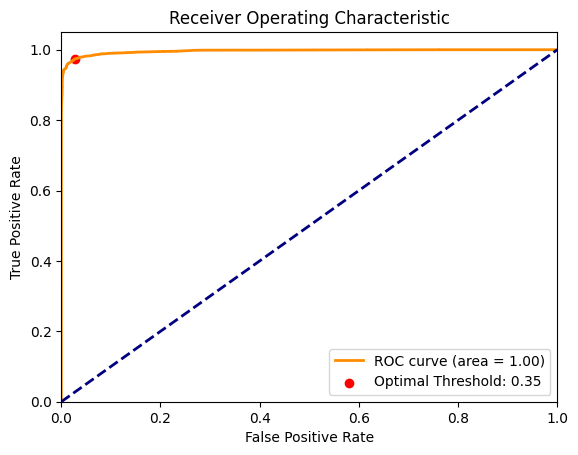

Optimal Threshold: 0.35


In [119]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))], tpr[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))], color='red', marker='o', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f'Optimal Threshold: {optimal_threshold:.2f}')

In [120]:
Y_train_predicted1 = np.where(Y_train_predicted_flatten >= optimal_threshold, 1, 0)
Y_train_predicted1

array([1, 1, 0, ..., 0, 0, 0])

In [121]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_train, Y_train_predicted1)
cm

array([[39782,  1090],
       [ 1098, 40112]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

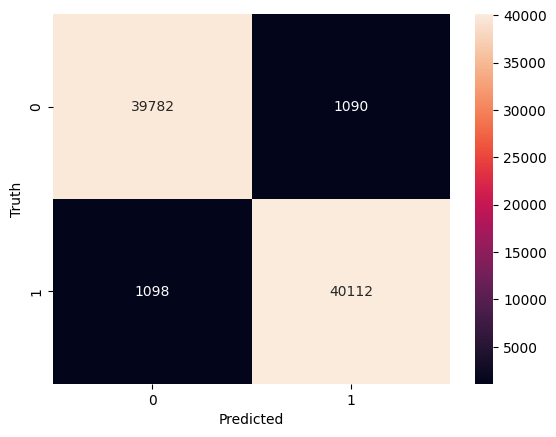

In [122]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [123]:
print(classification_report(y_train, Y_train_predicted1))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     40872
           1       0.97      0.97      0.97     41210

    accuracy                           0.97     82082
   macro avg       0.97      0.97      0.97     82082
weighted avg       0.97      0.97      0.97     82082



### Test from the train dataset

In [124]:
Y_val_predicted = model.predict(scaler.fit_transform(X_val_selected))

1100/1100 [==============================] - 8s 7ms/step


In [125]:
Y_val_predicted_flatten = Y_val_predicted.flatten()
Y_val_predicted_flatten

array([0.02039622, 0.9936568 , 0.9940267 , ..., 0.9247644 , 0.9866302 ,
       0.20607561], dtype=float32)

In [126]:
Y_val_predicted1 = np.where(Y_val_predicted_flatten >= optimal_threshold, 1, 0)
Y_val_predicted1

array([0, 1, 1, ..., 1, 1, 0])

In [127]:
cm = confusion_matrix(y_val, Y_val_predicted1)
cm

array([[17249,   509],
       [  488, 16932]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

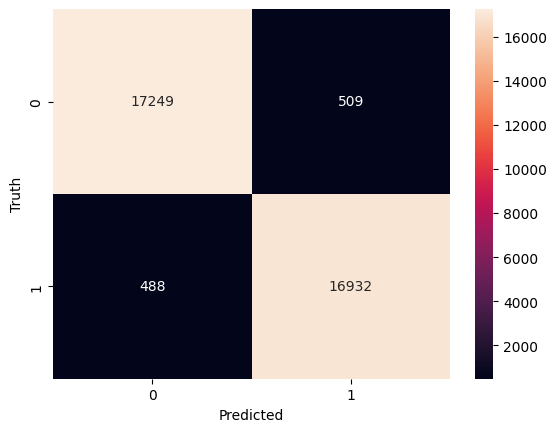

In [128]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [129]:
print(classification_report(y_val, Y_val_predicted1))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17758
           1       0.97      0.97      0.97     17420

    accuracy                           0.97     35178
   macro avg       0.97      0.97      0.97     35178
weighted avg       0.97      0.97      0.97     35178



# Testing Begins from here

In [130]:
Y_test_selected = test[selected_features]
Y_test_selected_scalar = scaler.transform(Y_test_selected)
y_test_predicted = model.predict(Y_test_selected_scalar)

705/705 [==============================] - 5s 7ms/step


In [131]:
y_test_predicted_flatten = y_predicted.flatten()
y_test_predicted_flatten

array([0.00459248, 0.00517774, 0.00264905, ..., 0.00296416, 0.05397737,
       0.0030009 ], dtype=float32)

In [142]:
# Assuming you have your binary classification model predictions and true labels
y_true1 = y_test
y_scores1 = y_test_predicted_flatten

fpr, tpr, thresholds = roc_curve(y_true1, y_scores1)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_threshold1 = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]
print(optimal_threshold1)

In [143]:
y_test_predicted1 = np.where(y_test_predicted_flatten >= optimal_threshold1, 1, 0)
y_test_predicted1

array([1, 1, 0, ..., 0, 1, 0])

In [144]:
cm = confusion_matrix(y_test, y_test_predicted1)
cm

array([[4168, 5543],
       [5513, 7320]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

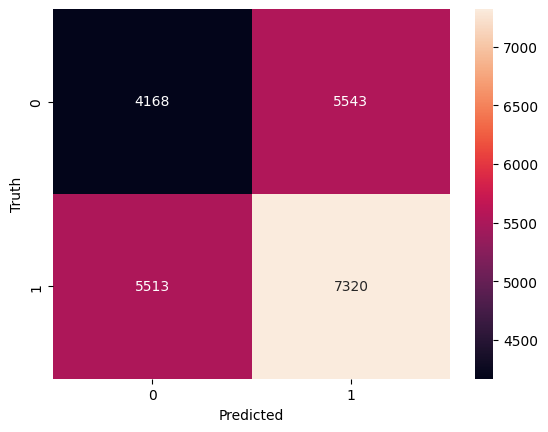

In [145]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [146]:
print(classification_report(y_test, y_test_predicted1))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43      9711
           1       0.57      0.57      0.57     12833

    accuracy                           0.51     22544
   macro avg       0.50      0.50      0.50     22544
weighted avg       0.51      0.51      0.51     22544

